# Benchmark Analysis - H1

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M'

In [5]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [6]:
plot_save_dir = './plots'

## Utils 

In [7]:
def get_path(*entries):
    return os.path.join(*entries)

In [8]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [9]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"))
    plt.show()

In [10]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [11]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [12]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [13]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

# H1
> Some parallel backends exhibit better performance and scalability when handling nested parallelism for homogeneous
> workloads
>

## Time 

## `b1_1_for_each_linear`

### Time Comparison - `b1_1_for_each_linear_par`
Check how the runtime without constraining the threads develops with increasing input size

In [14]:
# load data gcc (b1_1_for_each_linear_par)
b1_1_for_each_linear_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_1_for_each_linear_par__Default.csv',COMP="GCC(TBB)")

b1_1_for_each_linear_par_gcc = b1_1_for_each_linear_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_1_for_each_linear_par_gcc = b1_1_for_each_linear_par_gcc.rename(columns={'real_time':'GCC(TBB)'})

# load data nvhpc (b1_1_for_each_linear_par)
b1_1_for_each_linear_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_1_for_each_linear_par__Default.csv', COMP="NVC(OMP)")

b1_1_for_each_linear_par_nvc_omp = b1_1_for_each_linear_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_1_for_each_linear_par_nvc_omp = b1_1_for_each_linear_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})


# merge for ploting 
b1_1_for_each_linear_par_time_merged = pd.merge(b1_1_for_each_linear_par_gcc, b1_1_for_each_linear_par_nvc_omp, on='n')
b1_1_for_each_linear_par_time_merged

# convert time from ns to microseconds because otherwise it will look really bad
b1_1_for_each_linear_par_time_merged['GCC(TBB)'] = b1_1_for_each_linear_par_time_merged['GCC(TBB)'] / 1_000
b1_1_for_each_linear_par_time_merged['NVC(OMP)'] = b1_1_for_each_linear_par_time_merged['NVC(OMP)'] / 1_000

### Strong Scaling - `b1_1_for_each_linear` 
1 Million fixed input size with threads 1-64

In [15]:
# GCC
## load gcc (b1_1_for_each_linear_seq)
b1_1_for_each_linear_seq_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_1_for_each_linear_seq__Default.csv',COMP="GCC(TBB)")

## load gcc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)")

## calculate speedup
b1_1_for_each_linear_strong_scaling_seqbase_gcc = calc_speedup_based_seq(b1_1_for_each_linear_seq_gcc,b1_1_for_each_linear_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc (b1_1_for_each_linear_seq)
b1_1_for_each_linear_seq_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_1_for_each_linear_seq__Default.csv',COMP="NVC(OMP)")

## load nvhpc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)")

## calculate speedup
b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp = calc_speedup_based_seq(b1_1_for_each_linear_seq_nvc_omp,b1_1_for_each_linear_threads_nvc_omp,"NVC(OMP)")

# merge for plotting 
b1_1_for_each_linear_seq_speedup_merged = pd.merge(b1_1_for_each_linear_strong_scaling_seqbase_gcc, b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp, on='threads')
b1_1_for_each_linear_seq_speedup_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.998787,0.988248
1,2,1.995992,1.969824
2,4,3.910002,3.900383
3,8,7.946390,7.649651
4,16,15.681750,13.703228
5,32,27.473607,25.028300
6,64,53.912639,25.954861


In [16]:
## efficiency graph
b1_1_for_each_linear_seq_efficiency = b1_1_for_each_linear_seq_speedup_merged.copy()
b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] = b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] / b1_1_for_each_linear_seq_efficiency['threads']
b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] = b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] / b1_1_for_each_linear_seq_efficiency['threads']

b1_1_for_each_linear_seq_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.998787,0.988248
1,2,0.997996,0.984912
2,4,0.977500,0.975096
3,8,0.993299,0.956206
4,16,0.980109,0.856452
5,32,0.858550,0.782134
6,64,0.842385,0.405545


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_58344/2315424137.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


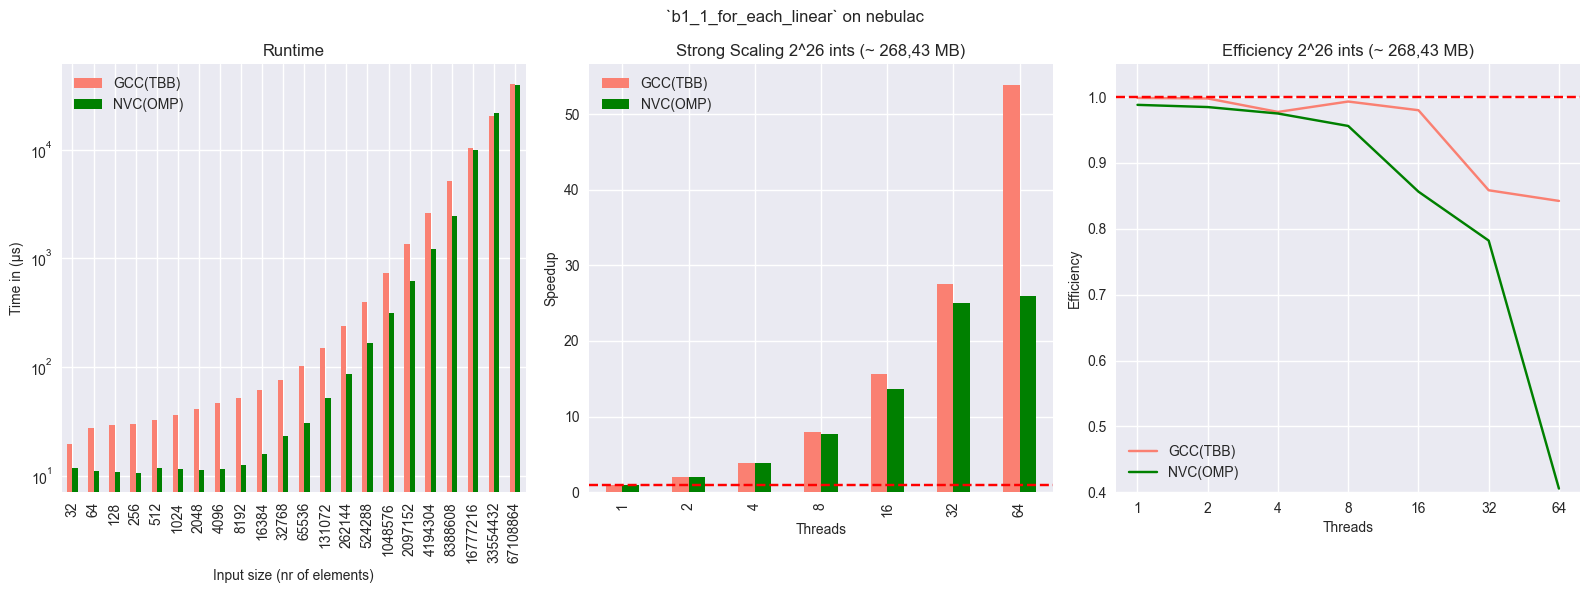

In [17]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# runtime 

ax_1 = b1_1_for_each_linear_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log',base=10)
ax_1.set_ylabel('Time in (µs)')
ax_1.set_xlabel('Input size (nr of elements)')
ax_1.set_title('Runtime')


# strong scaling 

ax_2 = b1_1_for_each_linear_seq_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# efficiency

# plot efficiency
ax_3 = b1_1_for_each_linear_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0.4,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')

fig.suptitle("`b1_1_for_each_linear` on nebulac")

fig.tight_layout()

plot("`b1_1_for_each_linear` on nebulac")


## `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par`

### Time Comparison - `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par`
Check how the runtime without constraining the threads develops with increasing input size

In [18]:
# load data gcc (b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par)
b1_2_for_each_quadratic_par_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par__Default.csv',COMP="GCC(TBB)")

b1_2_for_each_quadratic_par_par_gcc = b1_2_for_each_quadratic_par_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_2_for_each_quadratic_par_par_gcc = b1_2_for_each_quadratic_par_par_gcc.rename(columns={'real_time':'GCC(TBB)'})


# load data nvhpc (b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par)
b1_2_for_each_quadratic_par_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par__Default.csv',COMP="NVC(OMP)")

b1_2_for_each_quadratic_par_par_nvc_omp = b1_2_for_each_quadratic_par_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_2_for_each_quadratic_par_par_nvc_omp = b1_2_for_each_quadratic_par_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})

# merge for ploting 
b1_2_for_each_quadratic_par_par_time_merged = pd.merge(b1_2_for_each_quadratic_par_par_gcc, b1_2_for_each_quadratic_par_par_nvc_omp, on='n')

# convert time from ns to milliseconds because otherwise it will look really bad
b1_2_for_each_quadratic_par_par_time_merged['GCC(TBB)'] = b1_2_for_each_quadratic_par_par_time_merged['GCC(TBB)'] / 1_000_000
b1_2_for_each_quadratic_par_par_time_merged['NVC(OMP)'] = b1_2_for_each_quadratic_par_par_time_merged['NVC(OMP)'] / 1_000_000


Adding a second graph because small numbers are not readable in the above graph

In [19]:
b1_2_for_each_quadratic_par_par_time_merged_sub_4096 = b1_2_for_each_quadratic_par_par_time_merged[b1_2_for_each_quadratic_par_par_time_merged['n'] <= 4096]

### Strong Scaling - `b1_2_for_each_quadratic` 
1 Million fixed input size with threads 1-64

#### Seq Base

Here we wont do it with seq base because its not really realistic

#### Par(1) Base

In [20]:
# GCC(TBB)
## load gcc threaded b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par 
b1_2_for_each_quadratic_par_par_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32768)

## calc strong scaling
b1_2_for_each_quadratic_par_par_scaling_parbase_gcc = calc_speedup_based_par(b1_2_for_each_quadratic_par_par_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc threaded b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par 
b1_2_for_each_quadratic_par_par_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32768)

## calc strong scaling 
b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp = calc_speedup_based_par(b1_2_for_each_quadratic_par_par_threads_nvc_omp,"NVC(OMP)")

# merge for plotting
b1_2_for_each_quadratic_par_par_speedup_merged = pd.merge(b1_2_for_each_quadratic_par_par_scaling_parbase_gcc, b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp, on='threads')
b1_2_for_each_quadratic_par_par_speedup_merged


,threads,GCC(TBB),NVC(OMP)
0,1,1.000000,1.000000
1,2,1.997308,1.995406
2,4,3.983757,3.971343
3,8,7.957042,7.859529
4,16,15.840178,15.386907
5,32,27.031323,25.431066
6,64,49.615453,51.785683


In [21]:
## efficiency graph
b1_2_for_each_quadratic_par_par_efficiency = b1_2_for_each_quadratic_par_par_speedup_merged.copy()
b1_2_for_each_quadratic_par_par_efficiency['GCC(TBB)'] = b1_2_for_each_quadratic_par_par_efficiency['GCC(TBB)'] / b1_2_for_each_quadratic_par_par_efficiency['threads']
b1_2_for_each_quadratic_par_par_efficiency['NVC(OMP)'] = b1_2_for_each_quadratic_par_par_efficiency['NVC(OMP)'] / b1_2_for_each_quadratic_par_par_efficiency['threads']

b1_2_for_each_quadratic_par_par_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.000000,1.000000
1,2,0.998654,0.997703
2,4,0.995939,0.992836
3,8,0.994630,0.982441
4,16,0.990011,0.961682
5,32,0.844729,0.794721
6,64,0.775241,0.809151


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_58344/3481041322.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


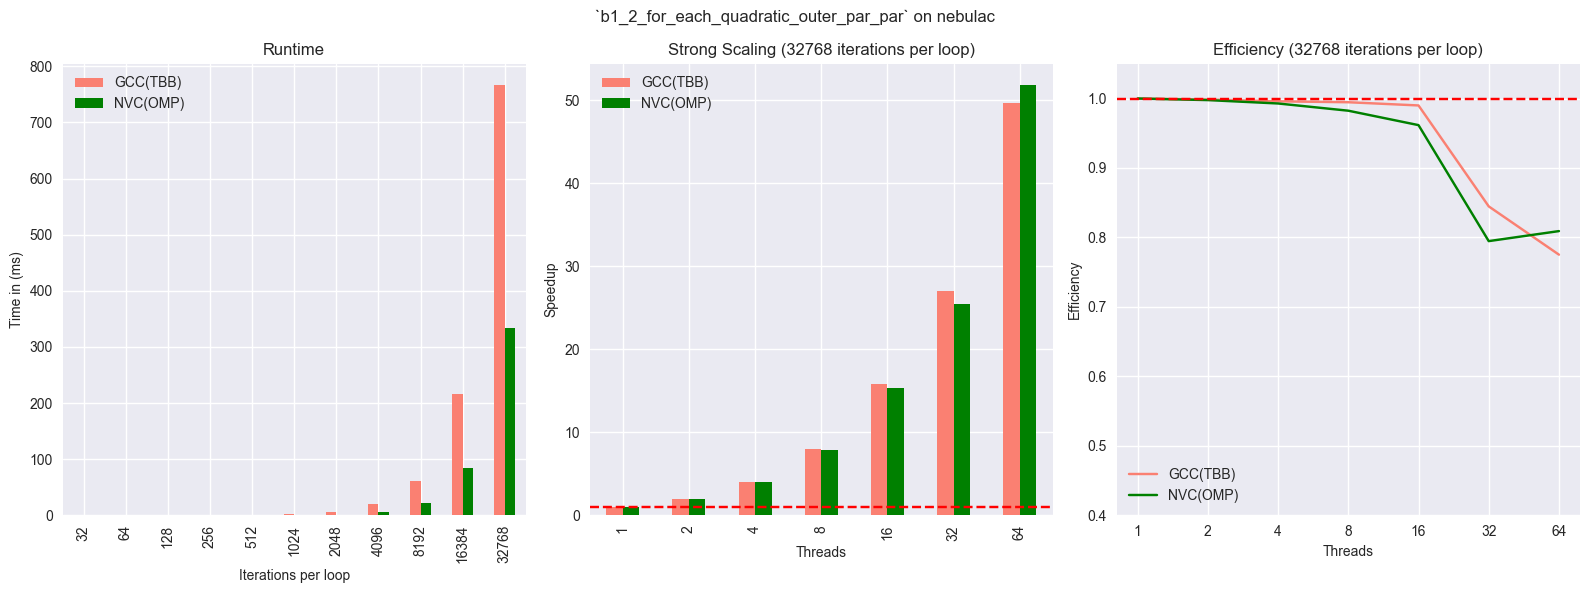

In [22]:
# all graphs for 

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# runtime full
ax_1 = b1_2_for_each_quadratic_par_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Time in (ms)')
ax_1.set_xlabel('Iterations per loop')
ax_1.set_title('Runtime')


# plot strong scaling
ax_3 = b1_2_for_each_quadratic_par_par_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')


ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Strong Scaling (32768 iterations per loop)')


# plot efficiency
ax_4 = b1_2_for_each_quadratic_par_par_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

# adding horizontal line where there is speedup
ax_4.axhline(y=1, color='r', linestyle='--')

ax_4.set_ylim(0.4,1.05)

ax_4.set_xscale('log', base=2)
current_values = ax_4.get_xticks()
ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('Efficiency (32768 iterations per loop)')

fig.suptitle("`b1_2_for_each_quadratic_outer_par_par` on nebulac")

fig.tight_layout()

plot('`b1_2_for_each_quadratic_outer_par_par` on Nebulac')


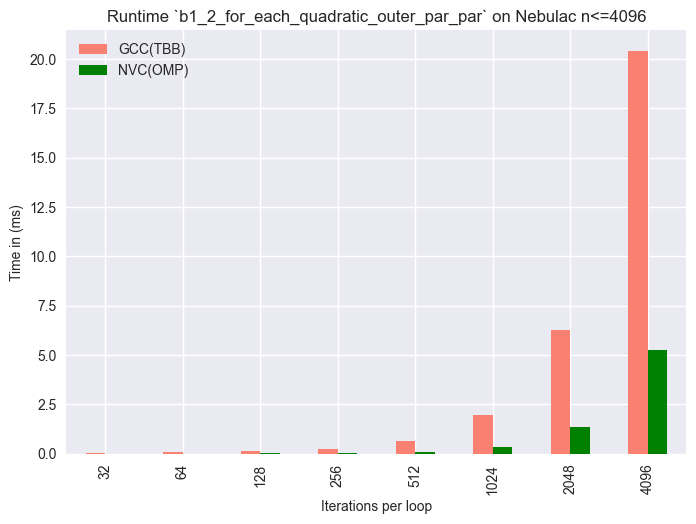

In [23]:
# plot runtime less than 4k
b1_2_for_each_quadratic_par_par_time_merged_sub_4096.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (ms)')
plt.xlabel('Iterations per loop')
plt.title('Runtime `b1_2_for_each_quadratic_outer_par_par` on Nebulac n<=4096')

plot('Runtime `b1_2_for_each_quadratic_outer_par_par` on Nebulac n<=4096')

## `b1_4_for_each_exponential_par`

### Time Comparison - `b1_4_for_each_exponential_par`
Check how the runtime without constraining the threads develops with increasing input size

In [24]:
# load data gcc (b1_4_for_each_exponential_par)
b1_4_for_each_exponential_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_4_for_each_exponential_par__Default.csv',COMP="GCC(TBB)")

b1_4_for_each_exponential_par_gcc = b1_4_for_each_exponential_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_4_for_each_exponential_par_gcc = b1_4_for_each_exponential_par_gcc.rename(columns={'real_time':'GCC(TBB)'})

# load data nvhpc (b1_4_for_each_exponential_par)
b1_4_for_each_exponential_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_4_for_each_exponential_par__Default.csv',COMP="NVC(OMP)")

b1_4_for_each_exponential_par_nvc_omp = b1_4_for_each_exponential_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_4_for_each_exponential_par_nvc_omp = b1_4_for_each_exponential_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})


# merge for ploting 
b1_4_for_each_exponential_par_time_merged = pd.merge(b1_4_for_each_exponential_par_gcc, b1_4_for_each_exponential_par_nvc_omp, on='n')

# convert time from ns to milliseconds because otherwise it will look really bad
b1_4_for_each_exponential_par_time_merged['GCC(TBB)'] = b1_4_for_each_exponential_par_time_merged['GCC(TBB)'] / 1_000_000
b1_4_for_each_exponential_par_time_merged['NVC(OMP)'] = b1_4_for_each_exponential_par_time_merged['NVC(OMP)'] / 1_000_000

b1_4_for_each_exponential_par_time_merged

,GCC(TBB),n,NVC(OMP)
0,0.020248,4,0.015820
1,0.115716,8,0.040826
2,0.500860,16,1.388890
3,87.688500,32,2808.290000


### Strong Scaling - `b1_4_for_each_exponential` 
32 fixed input size with threads 1-64

In [25]:
# GCC
## load gcc (b1_4_for_each_exponential_seq)
b1_4_for_each_exponential_seq_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_4_for_each_exponential_seq__Default.csv',COMP="GCC(TBB)")

## load gcc threaded b1_4_for_each_exponential_par 
b1_4_for_each_exponential_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32)

## calculate speedup
b1_4_for_each_exponential_strong_scaling_seqbase_gcc = calc_speedup_based_seq(b1_4_for_each_exponential_seq_gcc,b1_4_for_each_exponential_threads_gcc,"GCC(TBB)",input_size=32)

# NVC(OMP)
## load nvhpc (b1_4_for_each_exponential_seq)
b1_4_for_each_exponential_seq_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_4_for_each_exponential_seq__Default.csv',COMP="NVC(OMP)")

## load nvhpc threaded b1_4_for_each_exponential_par
b1_4_for_each_exponential_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32) 

## calculate speedup
b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp = calc_speedup_based_seq(b1_4_for_each_exponential_seq_nvc_omp,b1_4_for_each_exponential_threads_nvc_omp,"NVC(OMP)",input_size=32)


# merge for plotting 
b1_4_for_each_exponential_seq_speedup_merged = pd.merge(b1_4_for_each_exponential_strong_scaling_seqbase_gcc, b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp, on='threads')
b1_4_for_each_exponential_seq_speedup_merged



,threads,GCC(TBB),NVC(OMP)
0,1,0.234984,0.201489
1,2,0.279086,0.212861
2,4,0.585130,0.210758
3,8,1.166929,0.190555
4,16,2.322106,0.174034
5,32,4.118422,0.165106
6,64,7.034334,0.163106


In [26]:
## efficiency graph
b1_4_for_each_exponential_seq_efficiency = b1_4_for_each_exponential_seq_speedup_merged.copy()
b1_4_for_each_exponential_seq_efficiency['GCC(TBB)'] = b1_4_for_each_exponential_seq_efficiency['GCC(TBB)'] / b1_4_for_each_exponential_seq_efficiency['threads']
b1_4_for_each_exponential_seq_efficiency['NVC(OMP)'] = b1_4_for_each_exponential_seq_efficiency['NVC(OMP)'] / b1_4_for_each_exponential_seq_efficiency['threads']

b1_4_for_each_exponential_seq_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.234984,0.201489
1,2,0.139543,0.106431
2,4,0.146282,0.052689
3,8,0.145866,0.023819
4,16,0.145132,0.010877
5,32,0.128701,0.005160
6,64,0.109911,0.002549


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_58344/1019744152.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


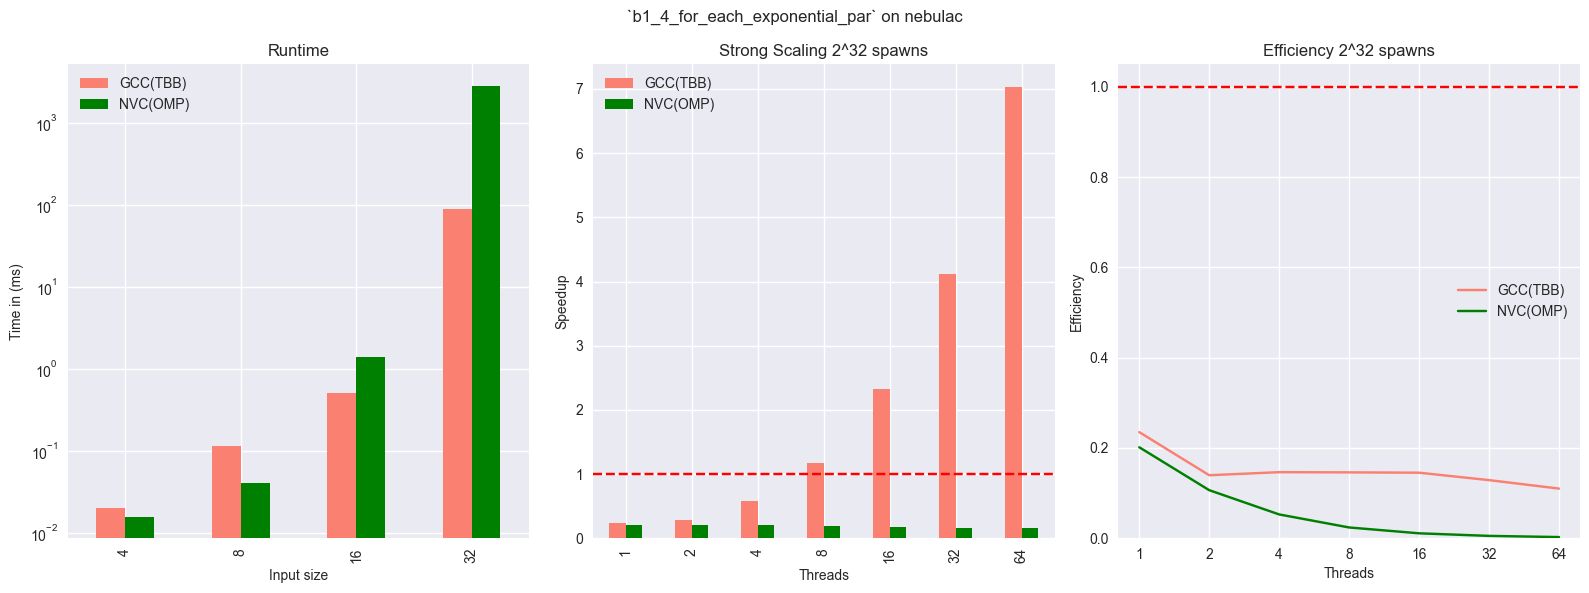

In [27]:
# total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))



# plot
ax_1 = b1_4_for_each_exponential_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log',base=10)
ax_1.set_ylabel('Time in (ms)')
ax_1.set_xlabel('Input size')
ax_1.set_title('Runtime')




# plot strong scaling
ax_2 = b1_4_for_each_exponential_seq_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^32 spawns')




# plot efficiency
ax_3 = b1_4_for_each_exponential_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^32 spawns')



fig.suptitle("`b1_4_for_each_exponential_par` on nebulac")
fig.tight_layout()


plot("`b1_4_for_each_exponential_par` on nebulac")


## Performance Portability Calculation (Inter Compiler)

for this group we can "calculate" a performance probability by looking at the strong scaling speedup every compiler has when using the max amount of cores. (aka running with 1M entries at max core) (insipred by [1])

example:

```
|          | achieved | perfect | efficiency  | 
|----------|----------|---------|-------------|
| GCC(TBB) | 12       | 16      | 12/16=0.75  |
| NVC(OMP) | 16       | 16      | 16/16=1     |
| NVC(GPU) | 0        | 0       | 0           |
| Intel    | 14       | 16      | 14/16=0.875 |

Performance Portability for `{GCC(TBB), NVC(OMP), NVC(GPU), Intel}` = 0

Performance Portability for `{GCC(TBB), NVC(OMP), Intel}` = `3/((1/0,75)+ (1/1) + (1/0,875))` = 86.3%

```

In [28]:
max_cores :int = 64


b1_1_data = []
b1_2_data = []
b1_4_data = []

print("GCC")
# calculate efficiency for gcc on max core for `b1_1_for_each_linear`
b1_1_for_each_linear_speed_up_64_gcc = b1_1_for_each_linear_strong_scaling_seqbase_gcc[b1_1_for_each_linear_strong_scaling_seqbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_1_data.append(b1_1_for_each_linear_speed_up_64_gcc)

print("\tb1_1 Speedup(64):", b1_1_for_each_linear_speed_up_64_gcc)


# calculate efficiency for gcc on max core for `b1_2_for_each_quadratic`
b1_2_for_each_quadratic_par_par_speed_up_64_gcc = b1_2_for_each_quadratic_par_par_scaling_parbase_gcc[b1_2_for_each_quadratic_par_par_scaling_parbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_2_data.append(b1_2_for_each_quadratic_par_par_speed_up_64_gcc)

print("\tb1_2 Speedup(64):", b1_2_for_each_quadratic_par_par_speed_up_64_gcc)



# calculate efficiency for gcc on max core for `b1_4_for_each_exponential`
b1_4_for_each_exponential_speed_up_64_gcc = b1_4_for_each_exponential_strong_scaling_seqbase_gcc[b1_4_for_each_exponential_strong_scaling_seqbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_4_data.append(b1_4_for_each_exponential_speed_up_64_gcc)

print("\tb1_4 Speedup(64):", b1_4_for_each_exponential_speed_up_64_gcc)


print("\nNVC(OMP)")
# calculate efficiency for nvhpc(mc) on max core for `b1_1_for_each_linear`
b1_1_for_each_linear_speed_up_64_nvc_omp = b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp[b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_1_data.append(b1_1_for_each_linear_speed_up_64_nvc_omp)

print("\tb1_1 Speedup(64):", b1_1_for_each_linear_speed_up_64_nvc_omp)

# calculate efficiency for nvhpc(mc) on max core for `b1_2_for_each_quadratic`
b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp = b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp[b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_2_data.append(b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp)

print("\tb1_2 Speedup(64):", b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp)

# calculate efficiency for nvhpc(mc) on max core for `b1_4_for_each_exponential`
b1_4_for_each_exponential_speed_up_64_nvc_omp = b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp[b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_4_data.append(b1_4_for_each_exponential_speed_up_64_nvc_omp)
print("\tb1_4 Speedup(64):", b1_4_for_each_exponential_speed_up_64_nvc_omp)

print("\n\n")

# calc
b1_1_perfect = max(b1_1_data)
b1_2_perfect = max(b1_2_data)
b1_4_perfect = max(b1_4_data)


# Performance portability b1_1 inter compiler
b1_1_efficiency = [x / b1_1_perfect for x in b1_1_data]
pp_b1_1 = len(b1_1_efficiency) / (sum([1 / x for x in b1_1_efficiency]))

print("Performance Portability B1_1: " , pp_b1_1)


# Performance portability b1_2 inter compiler
b1_2_efficiency = [x / b1_2_perfect for x in b1_2_data]
pp_b1_2 = len(b1_2_efficiency) / (sum([1 / x for x in b1_2_efficiency]))

print("Performance Portability B1_2: " , pp_b1_2)


# Performance portability b1_4 inter compiler
b1_4_efficiency = [x / b1_4_perfect for x in b1_4_data]
pp_b1_4 = len(b1_4_efficiency) / (sum([1 / x for x in b1_4_efficiency]))

print("Performance Portability B1_4: " , pp_b1_4)



GCC
	b1_1 Speedup(64): 53.912639428174565
	b1_2 Speedup(64): 49.615452885379916
	b1_4 Speedup(64): 7.03433382743546

NVC(OMP)
	b1_1 Speedup(64): 25.954860891498658
	b1_2 Speedup(64): 51.78568341219117
	b1_4 Speedup(64): 0.16310585844601008



Performance Portability B1_1:  0.6499479960588017
Performance Portability B1_2:  0.9785975719202741
Performance Portability B1_4:  0.04532329983006576


## Findings for H1

### `b1_1`
There is a significant runtime difference between parallel backends (TBB and NVC(OMP) ) when we are dealing with quite rudimentary linear homogenous workloads. As you can see in [figure of runtime comparisons](#time-comparison---b1_1_for_each_linear_par). The larger the input size gets the worse the performance of GCC(with TBB) gets. On the other side NVC(with OMP backend) seems to scale quite good under linear homogenous workloads.

For strong scaling we can see that calculating the speedup using the parallel implementation with 1 thread and using the sequential implementation, does not make a huge difference. In fact the overhead for this kind of workload seems to be minimal.
The backends scale fairly good and the absolute speedup for each number of threads does not have a tremendous difference between the two backends. We only start to notice that the more threads we utilize the larger the speedup between GCC(TBB) and NVC(OMP) gets. 

For small number of threads (1-16) we see that the speedup is quite optimal (close to perfect speedup). Only later when utilizing more threads (32+) we start to see a significant performance loss for both GCC(TBB) and NVC(OMP)

Since the performance portability metric used in this hypothesis focuses on the speedup and as observed above and the difference between speedup is not that huge, we achieve a rather high performance portability of **91%**!

Key observations:
* Significant runtime differences between GCC(TBB) and NVC(OMP)
* Speedup seems to be on same level for backends only for huge number of threads it starts to degrade
* Small number of threads nearly perfect speedup for both
* Performance portability quite high since backends behave quite good.


### `b1_2`
There is a signifcant runtime difference between parallel backends (TBB and NVC(OMP)) when we are dealing with nested quadratic parallelism (aka nested loops with each O(n)). As you can see in [figure of runtime comparisons](#time-comparison---b1_2_for_each_quadratic_outer_stdexecutionparallel_policy_par). The larger the input size gets the worse the performance of GCC(with TBB) gets. On the other side NVC(with OMP backend) seems to scale quite good under quadratic homogenous workloads.

For this benchmark we only considered the outer parallel and inner parallel with 1thread as base to calculate the speedups. GCC(TBB) seems to have better strong scaling than NVC(OMP). It looks like that NVC(OMP) starts to degrade heavily when having high number of threads and this is also visible when looking at the efficiency.

Since the performance portability metric used in this hypothesis focuses on the speedup and as observed above and the difference between speedup is actually quite huge, we achieve a rather poor portability of **79%**!

Key observations:
* Significant runtime differences between GCC(TBB) and NVC(OMP). NVC(OMP) faster than GCC(TBB)
* Speedup difference becomes bigger with rise of threads. 
* NVC(OMP) pretty much collapses at 64 threads.
* Small number of threads quite good for both backends
* Performance portability poor since NVC(OMP) collapses for high number of threads.



### `b1_4`
The runtime difference between GCC(TBB) and NVC(OMP) is extreme! Since we are dealing with exponential runtime it was expected that the runtime will increase fast, but the runtimes of NVC(OMP) exploded. At first the runtime of GCC(TBB) is worse than the of NVC(OMP), but when for larger input sizes the trend turns and the runtime of NVC(OMP) exploded and making GCC(TBB) faster by a magnitude.


For this kind of nested parallelism strong scaling does looks really bad. Using the sequential algorithm or the parallel algorithm with 1 Thread as base does not have an effect on the speedup for NVC(OMP). NVC(OMP) has really bad strong scaling and often does not even break the 1x speedup. On the other hand GCC(TBB) does improve significantly with more core reaching a speedup of more than 30x.

Since NVC(OMP) scales really bad on this kind of workload but GCC(TBB) really good, we achieve a rather poor portability of **6%**! 

### GPU Findings

Sadly NVC(GPU) does not support nested parallism. Although it would be possible to run `b1_1` with NVC(GPU) the rest of the benchmarks (`b1_2` and `b1_4`) do not. 

### Hypothesis Findings

The hypothesis is TRUE! 
